<a href="https://colab.research.google.com/github/abbas112/Classifier_accuracy/blob/main/pet_breeds_ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

abbasshahai_grizzly_bear_path = kagglehub.dataset_download('abbasshahai/grizzly-bear')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grizzly-bear/characteristics_480px_1200x.jpg.webp


In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [ ]:
(path/"images").ls()

(#7393) [Path('images/beagle_115.jpg'),Path('images/boxer_18.jpg'),Path('images/Maine_Coon_157.jpg'),Path('images/scottish_terrier_28.jpg'),Path('images/english_setter_6.jpg'),Path('images/american_pit_bull_terrier_79.jpg'),Path('images/boxer_128.jpg'),Path('images/Persian_265.jpg'),Path('images/Maine_Coon_182.jpg'),Path('images/keeshond_89.jpg'),Path('images/chihuahua_82.jpg'),Path('images/basset_hound_5.jpg'),Path('images/english_cocker_spaniel_144.jpg'),Path('images/scottish_terrier_108.jpg'),Path('images/British_Shorthair_116.jpg'),Path('images/boxer_10.jpg'),Path('images/basset_hound_194.jpg'),Path('images/beagle_85.jpg'),Path('images/japanese_chin_87.jpg'),Path('images/pug_40.jpg')...]

In [ ]:
fname = (path/'images').ls()[0]
fname

Path('images/beagle_115.jpg')

> # r means raw string, . matches any character except newline, + means one or more of the preceding tokens, () is a capture group we only need this part the regex should return, _ a literal underscore, we expect filenames to have an underscore before the number. /d is regex expression for any number from 0-9, + means one or multiple numbers, .jpg here dot is escaped dot, matching the literal dot before the jpg, jpg literally matches these three letters.

In [ ]:
re.findall(r"(.+)_\d+\.jpg", fname.name)

['beagle']

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(seed=42),
                get_y = using_attr(RegexLabeller(r'(.+)_\d+\.jpg'), 'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75)) # rotate,zoom,warp values set to default by FastAI
dls = pets.dataloaders(path/"images")

In [ ]:
from pathlib import Path
# this is for comparison of fastai augmentation approach and traditional approach - we uploaded the grizzly bear picture in dataset in kaggle.
img_path = Path("/kaggle/input/grizzly-bear/characteristics_480px_1200x.jpg.webp")
img_path


Path('/kaggle/input/grizzly-bear/characteristics_480px_1200x.jpg.webp')

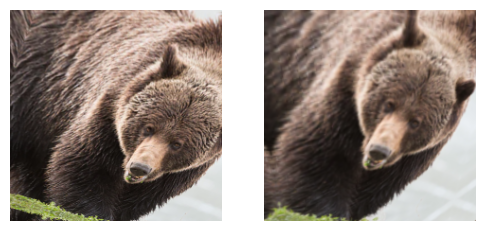

In [ ]:
# A comparison of fastai data augmentation straetgy(left) vs the traditional aproach(right)
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y = parent_label,
                   item_tfms=Resize(460))

#place an image in the 'images/grizzly,jpg' subfolder where this notebook is located before running this
# Build a toy dataloader of 100 copies of that one image
dls1 = dblock1.dataloaders([img_path]*100, bs=8) # we feed FastAI a list of 100 identical paths so we can easily grab batches
dls1.train.get_idxs = lambda: inf.ones # lock it down so every batch is that same one image, overrides the sampler to always pick index 1
x,y = dls1.valid.one_batch() # grab one batch from validation side, so we dont trigger random-train augmentations - x is a tensor of shape (8,3,460,460) - y are labels(all "grizzly")
_,axs = subplots(1, 2) # set up two side-by-side axes # we asking Matplitlib for a 1-row by 2-column gird of plots.

# Traditional manual augmentation and transformation
# each call (rotate, zoom, warp)--> 1.updates the coordinate grid 2.resamples the image to the new grid -> one interpolation per call. By the end you have done three separate inerpolations after the initial affine_coord
x1 = TensorImage(x.clone()) # copy your batch
x1 = x1.affine_coord(sz=224) # build a 224x224 coordinate grid
x1 = x1.rotate(draw=30, p=1.) # rotate 30° (always, p=1)
x1 = x1.zoom(draw=1.2, p=1.) # zoom in 20%
x1 = x1.warp(draw_x=0.2, draw_y=0.2, p=1.) # random warp

# FastAI's fused pipeline
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                      Warp(draw_x=0.2, draw_y=0.2, p=1., size=224)]) # p=1(always run this transform), draw=30°(rotate exactly by 30°), draw=1.2(zoom/scale by 1.2x(zoom in 20%)), draw_x=0.2(warp x-coordinates by up to 20% of the image width), draw_y=0.2(warp y-coordinates by up to 20% of the image heigh)
x = Pipeline(tfms)(x) # apply all transforms in one go
# x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

you can see image on the right is less well defined. and has reflection padding artefacts in the bottom right corner. We find that in practice, using **presizing** significantly increases the model accuracy, and often results in speedups too.

# Checking and Debugging a DataBlock

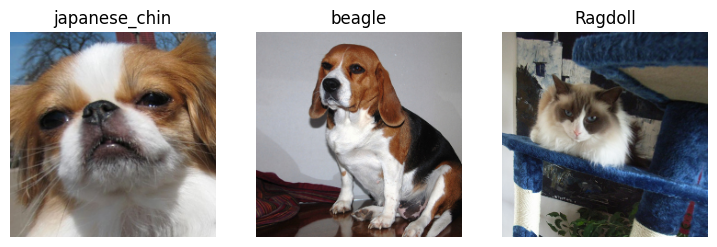

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/basset_hound_43.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/basset_hound_43.jpg
    applying partial gives
      basset_hound
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(14)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(14))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up afte

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 333])
	Item at index 1 has shape: torch.Size([3, 375, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 186MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.498300,0.342876,0.108931,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.505088,0.292662,0.094046,00:43
1,0.327477,0.237943,0.075101,00:44


In [ ]:
!nvidia-smi

Thu May 29 10:51:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             40W /   70W |    2823MiB /  15360MiB |     45%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Cross Entropy Loss**
In order to understand how cross entropy loss works on our dependent variable with two categories we first have to understand what the actual data and activations that are seen by loss function look like.

# Viewing Activations and Labels
to actually get a batch of real data from of dataset we can use the one_batch method:

In [ ]:
x, y = dls.one_batch()

in the following code our batch size is 64. so we have 64 rows in this tensor. each row is a single integer between 0-36, representing our 37 possible pet breeds.

In [ ]:
y

TensorCategory([15,  4, 29, 17, 33, 16, 17, 22, 31, 32, 25,  2, 27, 12, 34, 12,
                 4,  1, 18, 27, 35,  2, 12, 31,  1, 25, 28, 24, 35, 16, 33, 16,
                 1, 32,  9, 13,  0, 15, 24,  9, 33,  0, 32,  6,  7,  6, 19, 23,
                35,  6, 12, 21, 13,  2,  8,  8, 21, 17, 29,  3,  3,  5, 13,  4],
               device='cuda:0')

In [ ]:
# preds,_ = learn.get_preds(dl=[(x, y)])
# preds[0]

The actual predictions are probabilities between 0 and 1. We have 37 probabilities for image[i]. we sum all these 37 probabilities and get value equal to 1 in total.

In [ ]:
# len(preds[0]), preds[0].sum()

we can apply the following sigmoid function to a single column of activations from our neural network. so it gives a column of numbers between 0 and 1. so its a very useful function of our final layer.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

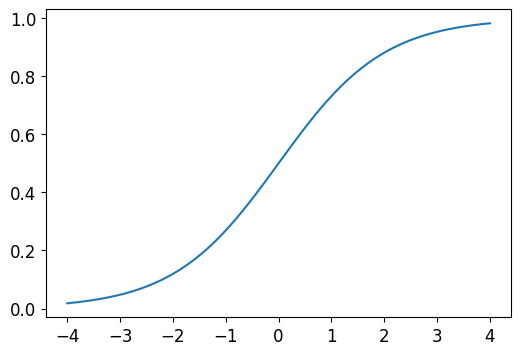

In [ ]:
!pip install fastbook
from fastbook import plot_function
plot_function(torch.sigmoid, min=-4, max=4)

In [ ]:
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

we compute the difference such as for first row--> 0.67 - 0.2576 =0.4158 , we plug this value into a sigmoid which is 1/ 1 + e**-d
the answer is 0.6025

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

dim=1 means as our dataset shape is (6,2) 6 images and 2 columns for class 0 and class 1. we want it to calculate softmax across these rows for dim=1 which is (2). so across these two columns to calculate softmax

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

softmax is the first part of our cross-entropy loss function. the second part is log-likelihood

In the binary case, we used torch.where to select between inputs and 1-inputs. When we treat a binary classification as a general classification problem with two categories, it actually becomes even easier, because (as we saw in the previous section) we now have two columns, containing the equivalent of inputs and 1-inputs. Since there is only one correct label per example, all we need to do is select the appropriate column (as opposed to multiplying multiple probabilities). Let's try to implement this in PyTorch. For our synthetic 3s and 7s example, let's say these are our labels:

In [ ]:
targ = tensor([0,1,0,1,1,0])

and following are the softmax activations

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
#!pip install --upgrade pandas
# from IPython.display import HTML
# df = pd.DataFrame(sm_acts, columns=["3", "7"])
# df['targ'] = targ
# df["idx"] = idx
# df['result'] = sm_acts[range(6), targ]
# t = df.style.hide_index()
# #to have the html code compatible with our script
# html = t._repr_html_().split('')[1]
# html = re.sub(r'', r'', html)
# display(HTML(html))
# error due to old pandas, styler object issue

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3", "7"])
df['targ'] = targ
df["idx"] = idx # sample number. so we can trace back from which row that specific image is.
df['result'] = sm_acts[range(6), targ] # a neat trick, range(6) is row selector. targ[0] or targ[1] is column selector.(each entry is 0 or 1)
# you already have df built...
html = df.to_html(index=False)      # <-- no index column
display(HTML(html))

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

despite its name(F.nll_loss) this function does not take the log. it assumes you have already taken the log. PyTorch has the function log_softmax that combines log and softmax in a fast accurate way. nll_loss is designed to be used after log_softmax

F.nll_loss takes the log-probability of the true class and negates it. reduction='none' means you get a vector of per-sample losses instead of a single averaged/scalar loss. you can then decide to .mean(), .sum() or weight them yourself.

In [ ]:
F.nll_loss(sm_acts, targ, reduction="none")

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

# Taking the Log


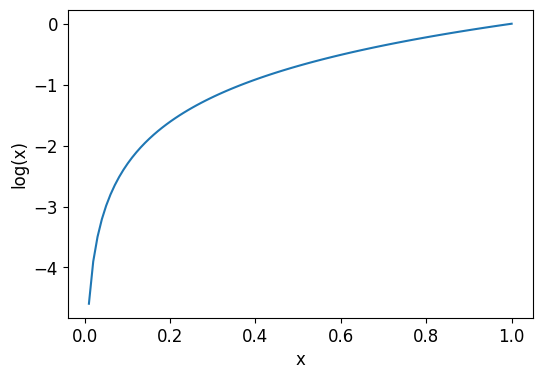

In [ ]:
plot_function(torch.log, min=0, max=1, ty='log(x)', tx='x')

the negative sign we add in the following code script. We want an optimizer which turns the maximize log problem into minimize loss problem.
it basically flips the negative values of log of x. because if we do loss(x) = log(x) then all our loss values are negative. our loss sits below zero the whole time. our optimizer goes the wrong way -> minimizing a negative number means making it more negative. and log(x) becomes more negative as x approaches zero x->0. so gradient descent would push our model toward predicting x=0 for the true class--i.e. it learns to be as wrong as possible.
---
without the minus, minimize log(x) pushes x toward 0.
---
with the minus, minimize(-log(x)) pushes x toward 1 as desired when the tru label is 1.

"""
In our case, since the result relfects the predicted probability of the correct label, we want our loss function to return a small value when the prediction is "good" (closer to 1) and a large value when the prediction is "bad" (closer to 0). We can achieve this by taking the negative of the log:
"""

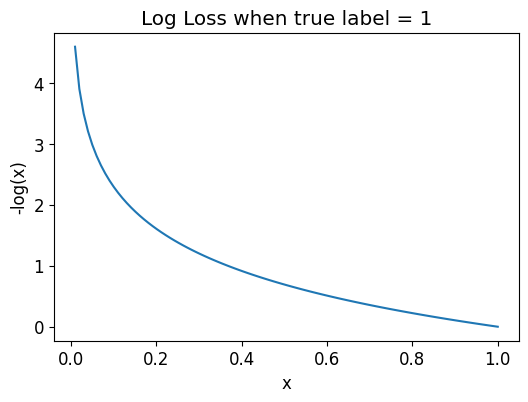

In [ ]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='-log(x)', title = 'Log Loss when true label = 1')

In [ ]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
html = df.to_html(index=False)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


In [ ]:
acts, targ

(tensor([[ 0.6734,  0.2576],
         [ 0.4689,  0.4607],
         [-2.2457, -0.3727],
         [ 4.4164, -1.2760],
         [ 0.9233,  0.5347],
         [ 1.0698,  1.6187]]),
 tensor([0, 1, 0, 1, 1, 0]))

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

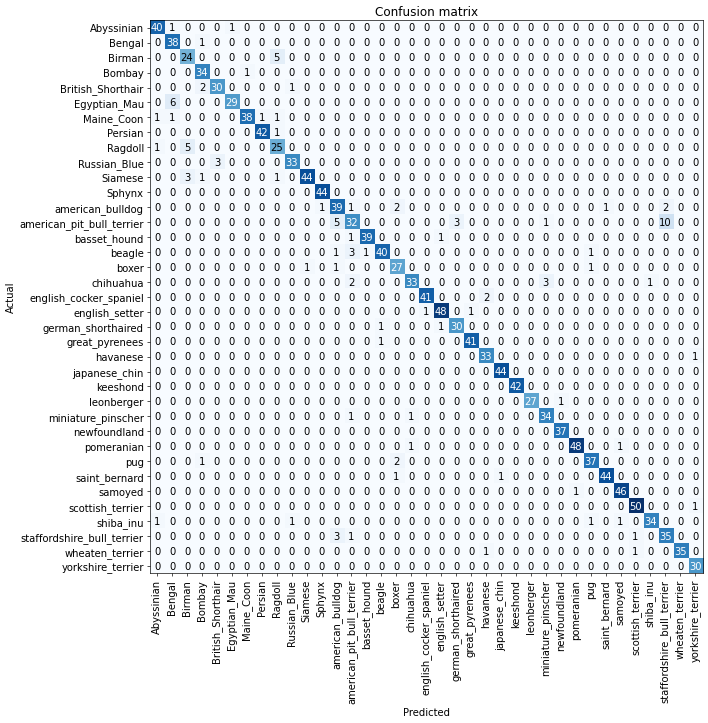

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Egyptian_Mau', 'Bengal', 6),
 ('Birman', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.500518,3.627512,0.384980,00:39


epoch,train_loss,valid_loss,error_rate,time
0,3.544427,2.106375,0.543978,00:46


the optimizer stepped in the correct direction. in the above result, but it stepped so far that it totally overshot the minimum loss and diverged.repeating that multiple times makes it get further and further away. not closer and closer

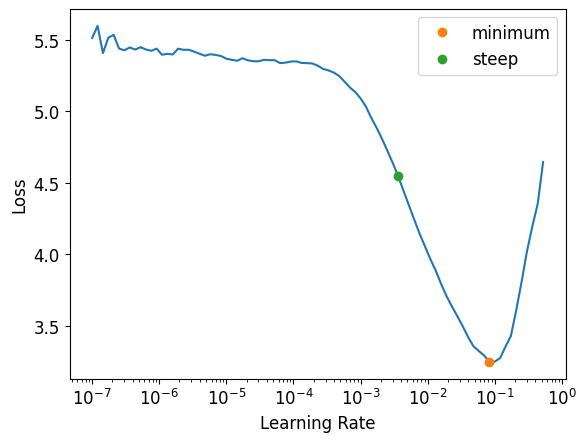

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

fastai function - suggest_funcs has division by 10 for lr_min baked in into it. so we get the lr_min in the following output as 1e-2 instead of 1e-1

In [ ]:
print(f'Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

Minimum/10: 8.32e-03, steepest point: 3.63e-03


in the following learning rate we chose 3e-3 though instead of 1e-2. --> 0.003 instead of 0.01

In [ ]:
lern = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.329904,0.341207,0.108254,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.548839,0.440310,0.129905,00:47
1,0.327507,0.246207,0.077131,00:47


In [ ]:
dls.train.bs, len(dls.train)

(64, 92)

In [ ]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py
Type:      method


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.118064,0.346205,0.110961,00:40
1,0.512775,0.250255,0.084574,00:39
2,0.321115,0.221197,0.076455,00:39


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

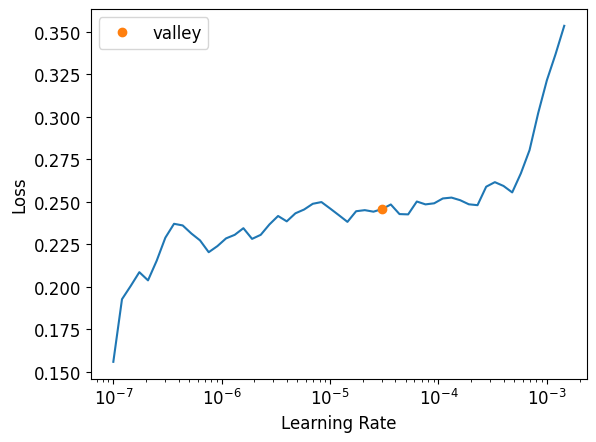

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.256106,0.214910,0.077131,00:48
1,0.242916,0.206094,0.075101,00:46
2,0.216476,0.205518,0.072395,00:47
3,0.185873,0.204864,0.069689,00:47
4,0.187787,0.198652,0.072395,00:47
5,0.178455,0.203287,0.071719,00:47


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.124757,0.311716,0.104195,00:40
1,0.524772,0.280487,0.096076,00:39
2,0.324424,0.237540,0.077131,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.257158,0.230645,0.075101,00:47
1,0.248454,0.228972,0.072395,00:47
2,0.251160,0.234211,0.073748,00:47
3,0.213048,0.218471,0.066306,00:47
4,0.182010,0.214023,0.069689,00:47
5,0.161500,0.205677,0.064953,00:47
6,0.165736,0.203937,0.062923,00:47
7,0.153962,0.203450,0.064276,00:47
8,0.142794,0.197796,0.064953,00:47
9,0.131472,0.199572,0.062246,00:48


In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,2.193530,0.448277,0.139378,00:35
1,0.858629,0.327814,0.102842,00:35
2,0.556890,0.299549,0.101489,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.302114,0.215474,0.069689,00:41
1,0.244674,0.240745,0.074425,00:40
2,0.198879,0.244515,0.070365,00:40
3,0.128643,0.182287,0.053451,00:40
4,0.076471,0.197076,0.053451,00:41
5,0.064599,0.187149,0.055480,00:40
